# 毕设说明书
---

## 地图匹配，将充电需求对应在路网图中

1.将充电需求对应在路网图中，路网图为二维平面，充电需求由车辆产生，根据充电需求产生的地址将其对应到路网图中的点，所述点称为需求点。
所述需求点从城市中车辆停留时间较长的位置产生，包括以下信息：充电需求产生的地址、充电需求产生的时间、预估的充电时长和车辆剩余行驶里程。

In [ ]:
'''
#1 —— 一次性执行
#t —— 测试单元，可删除
'''

In [28]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.pyplot import MultipleLocator
import random
from scipy.stats import truncnorm
import math

随机地图数据（包括地图块类型：小区、办公区、商贸区），地图设置为$1000\times1000$大小，其中小区占比：40%，办公区占比：30%,商贸区占比：10%

0-没有需求区域，1-小区，2-办公区，3-商贸区

In [13]:
# 常量定义
map_size = 100 #地图大小
map_step = 20  #划分地图

In [50]:
#1 使用随机直线划分格子
map_roll = np.sort(np.unique(np.random.randint(1, map_size, map_step-1)))#划分地图区域
map_cul = np.sort(np.unique(np.random.randint(1, map_size, map_step-1)))#划分地图区域
print(map_roll.size)
print(map_cul.size)

19
19


In [51]:
#1 写入文件 
np.savetxt('data/map_roll.txt', map_roll, fmt='%d', delimiter=',')
np.savetxt('data/map_cul.txt', map_cul, fmt='%d', delimiter=',')

In [14]:
# 从文件中读取
map_roll = np.loadtxt('data/map_roll.txt', delimiter=',', dtype=int)
map_roll = np.append(map_roll, map_size)
#map_roll = np.insert(map_roll, 0, 0)
map_cul = np.loadtxt('data/map_cul.txt', delimiter=',', dtype=int)
#map_cul = np.insert(map_cul, 0, 0)
map_cul = np.append(map_cul, map_size)

In [15]:
#t
print(map_cul)

[  3  29  32  34  38  43  46  57  60  61  72  80  82  83  84  87  93  94
  98 100]


In [88]:
#1 随机区域
map_rate = [0.2, 0.4, 0.3, 0.1]
map_x = np.arange(4)
map_distribution = np.random.choice(a=map_x, size=map_step**2, replace=True, p=map_rate)

In [91]:
#1 将区域信息写入文件
np.savetxt('data/map_distribution.txt', map_distribution, fmt='%d', delimiter=',')

In [16]:
# 读取区域
map_distribution = np.loadtxt('data/map_distribution.txt', delimiter=',', dtype=int)

In [17]:
#t 看比例
print(sum(map_distribution==0)/map_step**2)
print(sum(map_distribution==1)/map_step**2)
print(sum(map_distribution==2)/map_step**2)
print(sum(map_distribution==3)/map_step**2)

0.2175
0.41
0.285
0.0875


In [89]:
#1 将地图赋值     

mmap = np.ones((map_size,map_size), dtype=np.int) #地图

x_b = 0
y_b = 0
it_mapd = 0
for y_e in map_cul:
    for x_e in map_roll:
        mmap[x_b:x_e, y_b:y_e] *= map_distribution[it_mapd]
        x_b = x_e
        it_mapd += 1
    y_b = y_e

In [94]:
#1 将地图存入文件
np.savetxt('data/mmap.txt', mmap, fmt='%d', delimiter=',')

In [18]:
# 读取地图
mmap = np.loadtxt('data/mmap.txt', delimiter=',', dtype=int)

In [19]:
#t 查看每种区域的地图占比
print(sum(sum(mmap==0))/map_size**2)
print(sum(sum(mmap==1))/map_size**2)
print(sum(sum(mmap==2))/map_size**2)
print(sum(sum(mmap==3))/map_size**2)

0.1869
0.4496
0.2735
0.09


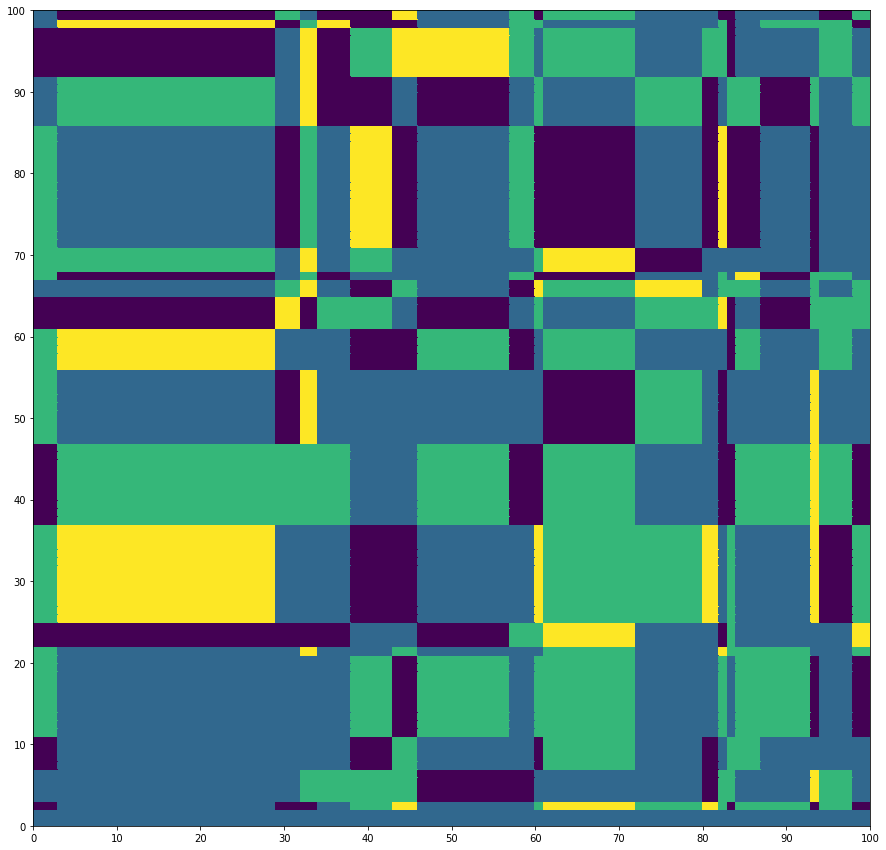

In [97]:
#t 将地图画出来
'''
0-其他区域-深深绿
1-住宅区-深绿
2-办公区-绿色
3-商贸区-黄色
'''
plt.figure(figsize=(15,15))
plt.pcolormesh(mmap,edgecolors='face')
#把x轴的刻度间隔设置为1，并存在变量里
x_major_locator=MultipleLocator(10)
#把y轴的刻度间隔设置为10，并存在变量里
y_major_locator=MultipleLocator(10)
#ax为两条坐标轴的实例
ax=plt.gca()
#把x轴的主刻度设置为50的倍数
ax.xaxis.set_major_locator(x_major_locator)
#把y轴的主刻度设置为50的倍数
ax.yaxis.set_major_locator(y_major_locator)
plt.show()

随机车辆，地图类型对需求产生的时间要求：
1. 住宅区：车辆需求点产生时间多半在中午和夜晚，时间17:00-21:00~7:00-9:00和11:00-12:00~13:30-14:00
2. 办公区：车辆需求点产生时间多半在上午和下午，时间7:00-9:00~11:00-12:00和13:30-14:00~17:00-21:00
3. 商贸区：时间8:00~21:00，时间段多数在2小时以上
4. 其他区域：时间不固定

随机的变量：充电需求产生的地址、充电需求产生的时间、预估的充电时长和车辆剩余行驶里程

随机车辆4000，其中2500遵循上班时间，1000遵循购物娱乐时间，500遵循在家时间

In [66]:
#1 随机时间
'''
car_cate
0-上班时间
时间：住宅区+办公区
地点：住宅+办公

1-娱乐时间
时间：住宅区+商贸区
地点：住宅+商贸

2-在家时间
时间：全天
地点：住宅
'''
#截断正态分布函数
def get_truncated_normal(mean=0, sd=1, low=0, upp=10):
    return truncnorm(
        (low - mean) / sd, (upp - mean) / sd, loc=mean, scale=sd)

car_num_0 = 2500
car_num_1 = 1000
car_num_2 = 500

# 上班时间
def cars_0():
    # 随机时间
    time_point_1_normal = get_truncated_normal(8.5, 1.5, 5, 10)
    time_point_1 = time_point_1_normal.rvs(car_num_0).reshape(car_num_0, 1)
    time_point_2_normal = get_truncated_normal(11.5, 0.5, 11, 12)
    time_point_2 = time_point_2_normal.rvs(car_num_0).reshape(car_num_0, 1)
    time_point_3_normal = get_truncated_normal(14, 0.5, 13, 15)
    time_point_3 = time_point_3_normal.rvs(car_num_0).reshape(car_num_0, 1)
    time_point_4_normal = get_truncated_normal(19, 1.5, 17, 21)
    time_point_4 = time_point_4_normal.rvs(car_num_0).reshape(car_num_0, 1)
    # 车辆id，为列向量
    car_id = np.arange(0,car_num_0).reshape(car_num_0, 1)
    # 随机地址
    addr_1_index = np.random.choice(a=np.argwhere(mmap==1).shape[0], size=car_num_0, replace=True)#住宅地址
    addr_1 = [np.argwhere(mmap==1)[i] for i in addr_1_index]
    addr_2_index = np.random.choice(a=np.argwhere(mmap==2).shape[0], size=car_num_0, replace=True)#办公地址
    addr_2 = [np.argwhere(mmap==2)[i] for i in addr_2_index]
    # 随机充电时长和剩余行驶里程(充电时长最长为3h, 行驶里程最长为500km)
    charge_time_normal = get_truncated_normal(1.5, 0.5, 0, 3)
    charge_time = charge_time_normal.rvs(car_num_0*4).reshape(car_num_0*4,1)
    remain_licheng = (3-charge_time)/3*500
    # 形成车辆需求
    
    car_id_con = np.concatenate((np.concatenate((car_id, car_id)), 
                                 np.concatenate((car_id, car_id))))
    time_point_con = np.concatenate((np.concatenate((time_point_1, time_point_2)), 
                                     np.concatenate((time_point_3, time_point_4))))
    addr_con = np.concatenate((np.concatenate((addr_2, addr_1)),
                               np.concatenate((addr_2, addr_1))))
    df_addr_con = pd.DataFrame(addr_con, columns = ['x','y'])
    #car_0_request = np.concatenate((np.concatenate((car_id_con, time_point_con), axis=1), 
    #                                np.concatenate((addr_con, charge_time), axis=1)), axis=1)
    #car_0_request = np.concatenate((car_0_request, remain_licheng), axis=1)
    # np.savetxt('data/car_0_request_test.txt', car_0_request, fmt='%f', delimiter=',')  
    df_car_0_request_read = pd.DataFrame(car_id_con, columns = ['车辆id'])
    df_car_0_request_read['充电需求产生的时间'] = time_point_con
    df_car_0_request_read['充电需求产生的地址'] = df_addr_con.apply(lambda r: tuple(r), axis=1).apply(np.array)
    df_car_0_request_read['预估充电时长'] = charge_time
    df_car_0_request_read['车辆剩余行驶里程'] = remain_licheng
    df_car_0_request_read.to_csv('data/df_car_0_request_read.csv')
    
    df_car_0_request = pd.DataFrame(car_id_con, columns = ['car_id'])
    df_car_0_request['time_point'] = time_point_con
    df_car_0_request['addr'] = df_addr_con.apply(lambda r: tuple(r), axis=1).apply(np.array)
    df_car_0_request['charge_time'] = charge_time
    df_car_0_request['remain_licheng'] = remain_licheng
    df_car_0_request.to_csv('data/df_car_0_request.csv')
    return df_car_0_request

# 娱乐时间
def cars_1():
    # 随机时间
    time_point_1_normal = get_truncated_normal(11, 1, 9, 13) # 去商场的时间点1
    time_point_1 = time_point_1_normal.rvs(int(car_num_1/2)).reshape(int(car_num_1/2), 1)
    time_point_2_normal = get_truncated_normal(15, 2, 13, 19) # 去商场的时间点2
    time_point_2 = time_point_2_normal.rvs(int(car_num_1/2)).reshape(int(car_num_1/2), 1)
    time_last_normal = get_truncated_normal(4, 1.5, 2, 11)
    time_last = time_last_normal.rvs(car_num_1).reshape(car_num_1, 1)
    time_point_temp = np.concatenate((np.concatenate((time_point_1, time_point_2)), time_last), axis=1)
    time_point_3 = np.zeros((car_num_1, 1))  #回住宅的时间
    tp_i = 0
    for tpt in time_point_temp: # 24小时制
        time_p = tpt[0]+tpt[1]
        if time_p > 24:
            time_p -= 24
        time_point_3[tp_i] = time_p
        tp_i += 1
    time_point_con = np.concatenate((np.concatenate((time_point_1, time_point_2)), time_point_3))
    # 车辆id，为列向量
    car_id = np.arange(car_num_0, car_num_0+car_num_1).reshape(car_num_1, 1)
    # 随机地址
    addr_1_index = np.random.choice(a=np.argwhere(mmap==1).shape[0], size=car_num_1, replace=False)#住宅地址
    addr_1 = [np.argwhere(mmap==1)[i] for i in addr_1_index]
    addr_3_index = np.random.choice(a=np.argwhere(mmap==3).shape[0], size=car_num_1, replace=True)#商贸地址
    addr_3 = [np.argwhere(mmap==3)[i] for i in addr_3_index]
    # 随机充电时长和剩余行驶里程(充电时长最长为3h, 行驶里程最长为500km)
    charge_time_normal = get_truncated_normal(1.5, 0.5, 0, 3)
    charge_time = charge_time_normal.rvs(car_num_1*2).reshape(car_num_1*2,1)
    remain_licheng = (3-charge_time)/3*500
    # 形成车辆需求
    car_id_con = np.concatenate((car_id, car_id))
    addr_con = np.concatenate((addr_3, addr_1))
    df_addr_con = pd.DataFrame(addr_con, columns = ['x','y'])
    #car_1_request = np.concatenate((np.concatenate((car_id_con, time_point_con), axis=1), 
    #                                np.concatenate((addr_con, charge_time), axis=1)), axis=1)
    #car_1_request = np.concatenate((car_1_request, remain_licheng), axis=1)
    # np.savetxt('data/car_1_request.txt', car_1_request, fmt='%f', delimiter=',')
    df_car_1_request_read = pd.DataFrame(car_id_con, columns = ['车辆id'])
    df_car_1_request_read['充电需求产生的时间'] = time_point_con
    df_car_1_request_read['充电需求产生的地址'] = df_addr_con.apply(lambda r: tuple(r), axis=1).apply(np.array)
    df_car_1_request_read['预估充电时长'] = charge_time
    df_car_1_request_read['车辆剩余行驶里程'] = remain_licheng
    df_car_1_request_read.to_csv('data/df_car_1_request_read.csv')
    
    df_car_1_request = pd.DataFrame(car_id_con, columns = ['car_id'])
    df_car_1_request['time_point'] = time_point_con
    df_car_1_request['addr'] = df_addr_con.apply(lambda r: tuple(r), axis=1).apply(np.array)
    df_car_1_request['charge_time'] = charge_time
    df_car_1_request['remain_licheng'] = remain_licheng
    df_car_1_request.to_csv('data/df_car_1_request.csv')
    return df_car_1_request


# 在家时间
def cars_2():
    # 随机时间
    time_point_normal = get_truncated_normal(12, 10, 0, 24)
    time_point = time_point_normal.rvs(car_num_2).reshape(car_num_2, 1)
    # 车辆id，为列向量
    car_id = np.arange(car_num_0+car_num_1,car_num_0+car_num_1+car_num_2).reshape(car_num_2, 1)
    # 随机地址
    addr_index = np.random.choice(a=np.argwhere(mmap==1).shape[0], size=car_num_2, replace=True)#住宅地址
    addr = [np.argwhere(mmap==1)[i] for i in addr_index]
    # 随机充电时长和剩余行驶里程(充电时长最长为3h, 行驶里程最长为500km)
    charge_time_normal = get_truncated_normal(1.5, 0.5, 0, 3)
    charge_time = charge_time_normal.rvs(car_num_2).reshape(car_num_2,1)
    remain_licheng = (3-charge_time)/3*500
    # 形成车辆需求
    df_addr_con = pd.DataFrame(addr, columns = ['x','y'])
    df_car_2_request_read = pd.DataFrame(car_id, columns = ['车辆id'])
    df_car_2_request_read['充电需求产生的时间'] = time_point
    df_car_2_request_read['充电需求产生的地址'] = df_addr_con.apply(lambda r: tuple(r), axis=1).apply(np.array)
    df_car_2_request_read['预估充电时长'] = charge_time
    df_car_2_request_read['车辆剩余行驶里程'] = remain_licheng
    df_car_2_request_read.to_csv('data/df_car_2_request_read.csv')
    
    df_car_2_request = pd.DataFrame(car_id, columns = ['car_id'])
    df_car_2_request['time_point'] = time_point
    df_car_2_request['addr'] = df_addr_con.apply(lambda r: tuple(r), axis=1).apply(np.array)
    df_car_2_request['charge_time'] = charge_time
    df_car_2_request['remain_licheng'] = remain_licheng
    df_car_2_request.to_csv('data/df_car_2_request.csv')
    return df_car_2_request
    
df_car_request = cars_0().append(cars_1()).append(cars_2())
df_car_request.to_csv('data/df_car_request.csv')

In [67]:
# 读取充电需求数据
df_car_request = pd.read_csv('data/df_car_request.csv', engine='python')
df_car_request.drop(df_car_request.columns[0], axis=1, inplace=True) # 删除第一列

,car_id,time_point,addr,charge_time,remain_licheng
0,0,9.337725,[10 70],2.244420,125.930053
1,1,9.011403,[41 61],1.261108,289.815344
2,2,7.804172,[42 9],1.871230,188.128271
3,3,6.097227,[12 61],1.822193,196.301196
4,4,8.883310,[42 89],1.497641,250.393143
5,5,8.991623,[60 70],1.363243,272.792789
6,6,9.490566,[13 64],1.143800,309.366717
7,7,8.265678,[89 14],1.359553,273.407808
8,8,7.362807,[18 63],1.772960,204.506585
9,9,7.120087,[88 11],1.573192,237.801339


## 预测城市充电需求，确定充电热区

该步骤是使用基于区域充电需求量的聚类算法实现的，具体步骤如下：
1. 数据清洗，由于会出现多个充电需求对应到同一需求点的情况，需要统计每个充电需求中预估的充电时长，之后计算每个需求点的平均预估的充电时长作为该需求点的需求分数，公式如下：
$$SC_p=\frac{\sum_{i=1}^{n}ST_i}{n}$$
其中$SC_p$表示需求点$p$的需求分数，$ST_i$表示对应到需求点$p$的第$i$个充电需求中的预估充电时长，$n$表示历史记录中对应到该点的需求个数
2. 删除需求分数过低的需求点，根据预先设置的阈值，删除需求分数低于阈值的需求点；
3. 使用K-means算法将需求点进行聚类，得到不同密度的簇，即充电热区，其代表着有一定充电需求的区域。

其中，步骤3中聚类个数K使用肘部法则来确定，将各个簇内的样本点到所在簇质心的距离平方和（SSE）作为性能度量，越小则说明各个类簇越收敛。但不是SSE越小越好，肘部法则就是在类簇数量与SSE之间寻求一个平衡点，具体步骤如下：

(1)指定一个i值，即可能的最大类簇数；

(2) 然后将类簇数从1开始递增，一直到$i$，计算出$i$个$SSE$，公式如下：
$$SSE=\sum_{k=1}^{k}\sum_{i\epsilon C_k}^{i}\lvert x_i-\mu k \rvert$$
其中，$\mu k$是第k个质心的位置

(3)通过画出K-SSE曲线，找出下降途中的拐点，即可较好的确定K值。

In [ ]:
# 

## 调整充电热区，确定充电站候选区域

总体方法为融合较小的簇、分割较大的簇，具体步骤如下：
1. 计算充电热区的半径和充电热区之间的距离矩阵；
2. 若某一充电热区和其他充电热区的距离小于r，则以半径r合并充电热区，其中r与电动汽车充满电的续航里程相关，r是为了保证电动汽车的剩余电量可以支撑其行驶到充电站，根据历史数据中电动汽车在该区域的平均剩余电量，可以利用现有方法估算行驶里程l，则$r=l$
3. 若充电热区的半径大于阈值r则在该热区内再次运行K-means算法划分新的充电热区，重复步骤1；
4. 得到充电站候选区域集合。

## 确定充电站内的充电桩数量

1. 统计候选区域内候选点的停留时长及其时间段（每小时为1个时间段）；
2. 将停留时长除以3作为该候选点在其停留时间段的充电需求值； 
3. 统计候选区域内所有时间段的充电需求和，将其作为候选区域的充电桩数量。

## 利用遗传算法实现最优布局

1. 创建初始种群，在遗传算法中，使用固定长度的二进制串来表示群体中的个体，将n个候选点编号为1-n，并根据是否设置充电站，将染色体上的基因进行编码，由{0，1}组成，0表示不设置充电站，1表示设置充电站；
2. 设置种群的个体适应度函数，个体适应度函数是布局目标的数学表达，考虑两个因素——用户和管理者因素，具体为用户的时间费用（平均行驶时间、充电排队时间）、管理者的建站费用（充电站的个数），公式如下：
$$S=\sum_{i\epsilon C}(\frac{\lambda_1}{num_j}\sum_{j\epsilon C_i}(t_{j1}+t_{j2})+\lambda_2\frac{1}{num_i})$$
其中，$C$表示充电站集合，表示第$i$个充电站，$j$表示选择作为充电目标的电动汽车，$t_{j1}$表示行驶时间，$t_{j2}$表示排队时间，$num_j$和$num_i$分别表示充电站的个数和选择此充电站的电动汽车个数，$\lambda_1$和$\lambda_2$代表用户时间费用和管理者建站费用的系数，通过实验得出，因此，布局目标是用户到达最近充电站的耗时和成电站个数最少。
3. 执行遗传算子不断迭代得到最终解；